In [3]:
from altaipony.lcio import from_mast, from_path
from altaipony.flarelc import FlareLightCurve
from altaipony.altai import find_iterative_median
from lightkurve import search_targetpixelfile, search_lightcurvefile

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import pandas as pd

import copy

def refine_detrended_flux_err(flcd, mask_pos_outliers_sigma=2.5, 
                              std_rolling_window_length=15, pad=25):
    """Attempt to recover a good estimate of the ligh curve noise.
    Start out from a simple standard deviation of the flux.
    Then filter out outliers above `mask_pos_outliers_sigma`.
    Apply rolling window standard deviation on the filtered array.
    Calculate a mean standard deviation from the result.
    Fill in this mean into the masked values.

    Parameters:
    -----------
    flcd : de-trended FlareLightCurve

    mask_pos_outliers_sigma : float
        sigma value above which to mask positive outliers
    std_rolling_window_length : int
        rolling window length for standard deviation calculation
    pad : int
        How many values to pad-mask around positive outliers.

    Return:
    --------
    FlareLightCurve with refined `detrended_flux_err` attribute.

    """

    # start with a first approximation to std
    flcd.detrended_flux_err[:] =  np.nanstd(flcd.detrended_flux)

    # and refine it:
    flcd = find_iterative_median(flcd)

    filtered = copy.deepcopy(flcd.detrended_flux)

    # mask strong positive outliers so that they don't add to std
    filtered[flcd.detrended_flux - flcd.it_med > mask_pos_outliers_sigma * flcd.detrended_flux_err] = np.nan

    # apply rolling window std
    flcd.detrended_flux_err[:] = pd.Series(filtered).rolling(std_rolling_window_length, min_periods=1).std()

    # set std to mean value if calculation fails to inf
    meanstd = np.nanmean(flcd.detrended_flux_err)

    # pad the excluded values not to create spikes of high error around flares
    isin = np.invert(np.isfinite(flcd.detrended_flux_err))
    x = np.where(isin)[0]
    for i in range(-pad, pad+1):
        y = x + i
        y[np.where(y > len(isin) - 1)] = len(isin) - 1
        isin[y] = True

    x = np.where(isin)[0]
    flcd.detrended_flux_err[x] = meanstd

    return flcd

import time

/home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/importlib/_bootstrap_external.py:426: ImportWarning: Not importing directory /home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/site-packages/mpl_toolkits: missing __init__
  _warnings.warn(msg.format(portions[0]), ImportWarning)
/home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/site-packages/bokeh/resources.py:107: ResourceWarning: unclosed file <_io.TextIOWrapper name='/home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/site-packages/bokeh/_sri.json' mode='r' encoding='UTF-8'>
  _SRI_HASHES = json.load(open(join(ROOT_DIR, "_sri.json")))
/home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [2]:
clus = pd.read_csv("lost_lcs.sh",delimiter=" ",#joblistonlyk2sc
                 names = ["python","call","EPIC","channel","C","cluster"
                         ])

In [4]:
df = pd.read_csv("../k2scoc/results/tables/2020_05_final_flares.csv")
#df = pd.read_csv("../k2scoc/results/tables/lost_table.csv")
#df = df[df.real==1]

In [3]:
a, b = dfold[["EPIC","C"]].drop_duplicates(), df[["EPIC","C"]].drop_duplicates()
a.merge(b, how="inner", on=["EPIC","C"])

NameError: name 'dfold' is not defined

In [5]:
df2 = df#[(df.real==1) & (df.note == "complex!") &(~df.note.isnull())]#
#df2.sort_values(by=["ed_rec"], ascending=False)[["cstart","cstop","EPIC","C","note","ed_rec",]].head(3)

In [10]:
EPIC = 210651981




C = 13
subdf = df[(df.C==C) & (df.EPIC==EPIC) & (df.istop - df.istart > 2)]

flc = from_path(f"../k2scoc/pony_k2sc_k2_llc_{EPIC}-c{C:02d}_kepler_v2_lc.fits", mode="AltaiPony", mission="K2")

/home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/site-packages/altaipony-0.0.1-py3.6.egg/altaipony/lcio.py:139: ResourceWarning: unclosed file <_io.FileIO name='../k2scoc/pony_k2sc_k2_llc_210651981-c13_kepler_v2_lc.fits' mode='rb' closefd=True>
  return _from_path_AltaiPony(path)


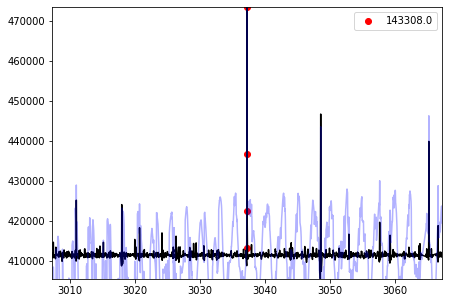

In [13]:

for i, r in subdf.iterrows():
    plt.figure(figsize=(7,5))
    plt.plot(flc.time, flc.detrended_flux,c="k")
    plt.plot(flc.time, flc.flux,c="b", alpha=.3)
    sta, sto = int(r.istart), int(r.istop)+1
    plt.scatter(flc.time[sta:sto], flc.detrended_flux[sta:sto], c="r", label=r.cstart)#, label=f"EPIC {EPIC}, C{C}")#
    plt.xlim(r.tstart-30,r.tstop+30)
    plt.ylim(np.nanmin(1.*flc.detrended_flux),1.*np.nanmax(flc.detrended_flux))
    plt.legend()
   # plt.savefig(f"plots/EPIC_{EPIC}_C{C}_{r.istart}_multiperiod.png",dpi=300)
    #print(r.istart)

## View also TPF

In [12]:
EPIC = 211915785


C = 5
tpf = search_targetpixelfile("EPIC {}".format(EPIC), campaign=C).download()


Found cached file /home/ekaterina/.lightkurve-cache/mastDownload/K2/ktwo211915785-c05_lc/ktwo211915785-c05_lpd-targ.fits.gz with expected size 1775381.
6% (217/3663) of the cadences will be ignored due to the quality mask (quality_bitmask=1130799).
6% (217/3663) of the cadences will be ignored due to the quality mask (quality_bitmask=1130799).


In [13]:
#tpf = tpf[~np.isnan(tpf.flux)]
tpf.interact(notebook_url="http://localhost:8888")


Starting Bokeh server version 2.0.0 (running on Tornado 6.0.4)
User authentication hooks NOT provided (default user enabled)


200 GET /autoload.js?bokeh-autoload-element=7437&bokeh-absolute-url=http://localhost:44145&resources=none (127.0.0.1) 213.11ms
101 GET /ws (127.0.0.1) 0.70ms
WebSocket connection opened
ServerConnection created


In [5]:
# EPIC = 211396661


# C = 18
tpf = search_lightcurvefile("TIC 197570458", sector=1).download()


Found cached file /home/ekaterina/.lightkurve-cache/mastDownload/TESS/tess2018206045859-s0001-0000000197570458-0120-s/tess2018206045859-s0001-0000000197570458-0120-s_lc.fits with expected size 2039040.
10% (1972/20076) of the cadences will be ignored due to the quality mask (quality_bitmask=175).
10% (1972/20076) of the cadences will be ignored due to the quality mask (quality_bitmask=175).


In [7]:
lc= tpf.get_lightcurve("PDCSAP_FLUX")

(1320.0, 1330.0)

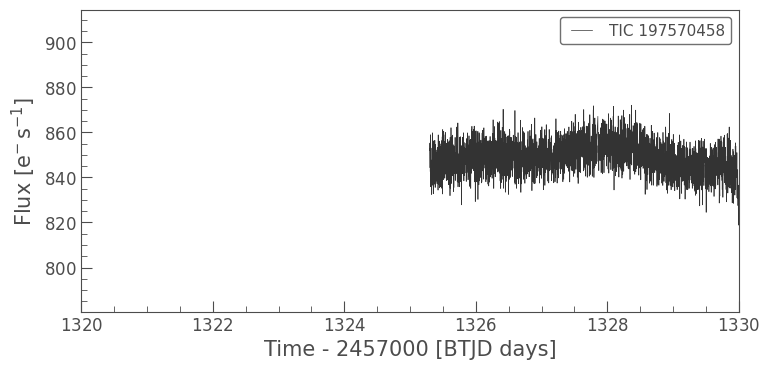

In [15]:
lc.plot()
plt.xlim(1320,1330)

In [ ]:
# import seaborn as sns
# from matplotlib.colors import PowerNorm
# %matplotlib inline
# ras = tpf.get_coordinates(cadence=0)[0]
# decs = tpf.get_coordinates(cadence=0)[1]
# labels = np.chararray(ras.shape, itemsize=20, unicode=True)

# for i, row in enumerate(ras):
#     if i%5==0:
#         for j, col in enumerate(row):
#             if j%5 ==0:
#         #         l = "{:.4f}\n{:.4f}".format(col-tpf.ra, decs[i][j]-tpf.dec)
#                # l = "{:.4f}\n{:.4f}".format(col-92.154527, decs[i][j]-24.233511)
#                 l = "{:.03f}".format(100*np.sqrt((col-92.154527)**2+(decs[i][j]-24.233511)**2))
#                 labels[i][j] = l

# fig, ax = plt.subplots(figsize=(10,8))
# sns.heatmap(tpf.flux[0][:][::-1], annot = labels[:][::-1], fmt = '', ax=ax, cmap="viridis", norm=PowerNorm(gamma=1./2.))

In [ ]:
250./15000


In [ ]:
5483/(1300/4.5)

In [ ]:
1.04875383187081e32*60
